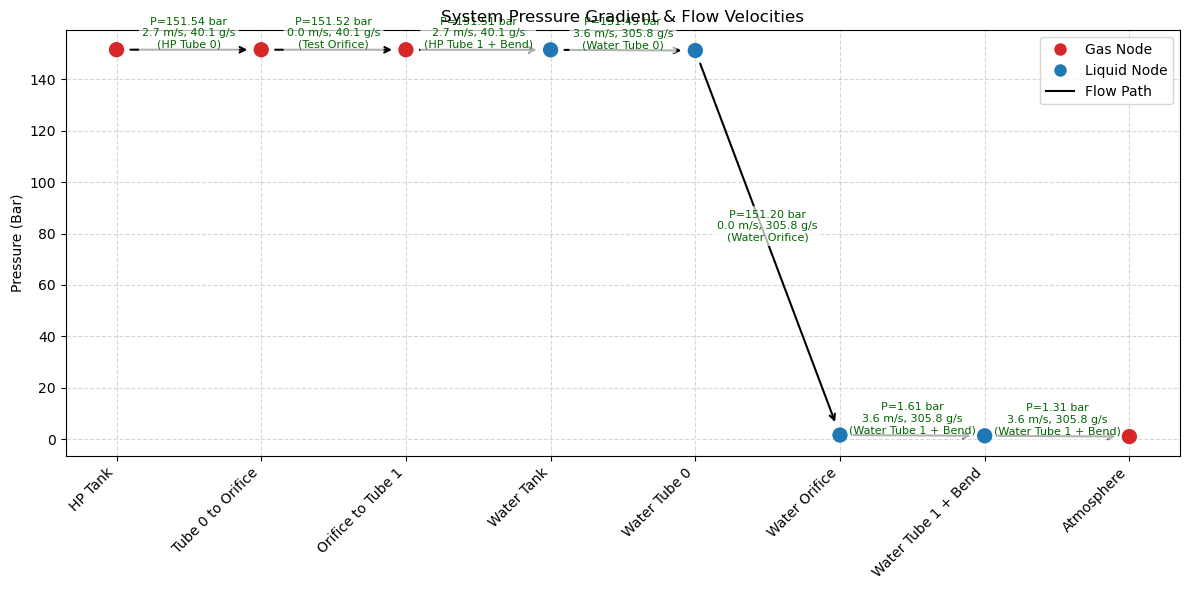

In [26]:
from flowobjects import Gas, Liquid, Tank, FlowComponent, FluidNode, plot_pressure_network, TubeComponent, dae_system, initialize_tanks, timed_valve_kv, regulator_kv

e_ss = 1.5e-6

air = Gas(name="Air",R= 287, gamma = 1.4, viscosity=1.8e-5)
water = Liquid(name="Water", density = 1000, viscosity=0.001)
    
hp_tank = Tank(name='HP Tank', volume=3.78 * 0.001 * 2, pressure = 200e5, gas=air, gas_temp=300)
hp_tube_0 = TubeComponent(name='HP Tube 0', D=0.01042, L=2, roughness=e_ss, bend_ang=0, K_extra=0)
orifice_0 = FlowComponent(name='Test Orifice', kv=3)
hp_tube_1 = TubeComponent(name='HP Tube 1 + Bend', D=0.01042, L=2, roughness=e_ss, bend_ang=45, K_extra=0.1)
water_tank = Tank(name='Water Tank', volume=0.005, mass_liquid=0.004*1000, pressure = 25e5, gas=air, gas_temp=300, liquid=water)
water_tube_0 = TubeComponent(name='Water Tube 0', D=0.01042, L=2, roughness=e_ss, bend_ang=0, K_extra=0)
water_orifice = FlowComponent(name='Water Orifice', kv=0.09)
water_tube_1= TubeComponent(name='Water Tube 1 + Bend', D=0.01042, L=2, roughness=e_ss, bend_ang=45, K_extra=0.1)

hp_tank_node = FluidNode("HP Tank", tank=hp_tank, pressure=hp_tank.pressure, temperature=hp_tank.gas_temp, fluid=hp_tank.gas)
tube0_to_orifice = FluidNode("Tube 0 to Orifice", pressure=hp_tank.pressure, temperature=hp_tank.gas_temp, fluid=hp_tank.gas) 
orifice_to_tube1 = FluidNode("Orifice to Tube 1", pressure=hp_tank.pressure, temperature=hp_tank.gas_temp, fluid=hp_tank.gas) 

water_tank_node = FluidNode("Water Tank", tank=water_tank, pressure=water_tank.pressure, temperature=water_tank.liquid_temp, fluid=water_tank.liquid)
water_tube_0_node = FluidNode("Water Tube 0", pressure=water_tank.pressure, temperature=water_tank.liquid_temp, fluid=water_tank.liquid)
water_orifice_node = FluidNode("Water Orifice", pressure=water_tank.pressure, temperature=water_tank.liquid_temp, fluid=water_tank.liquid)
water_tube_1_node = FluidNode("Water Tube 1 + Bend", pressure=water_tank.pressure, temperature=water_tank.liquid_temp, fluid=water_tank.liquid)

atmosphere_node = FluidNode("Atmosphere", pressure=101325, constant_pressure=True, temperature=300, fluid=air)

hp_tank_node.connect_nodes([(tube0_to_orifice, hp_tube_0, False)])
tube0_to_orifice.connect_nodes([(hp_tank_node, hp_tube_0, True), (orifice_to_tube1, orifice_0, False)])
orifice_to_tube1.connect_nodes([(tube0_to_orifice, orifice_0, True), (water_tank_node, hp_tube_1, False)])
water_tank_node.connect_nodes([(orifice_to_tube1, hp_tube_1, True), (water_tube_0_node, water_tube_0, False)])
water_tube_0_node.connect_nodes([(water_tank_node, water_tube_0, True), (water_orifice_node, water_orifice, False)])
water_orifice_node.connect_nodes([(water_tube_0_node, water_orifice, True), (water_tube_1_node, water_tube_1, False)])
water_tube_1_node.connect_nodes([(water_orifice_node, water_tube_1, True), (atmosphere_node, water_tube_1, False)])
atmosphere_node.connect_nodes([(water_tube_1_node, water_tube_1, True)])

total_nodes = [hp_tank_node, tube0_to_orifice, orifice_to_tube1, water_tank_node, water_tube_0_node, water_orifice_node, water_tube_1_node, atmosphere_node]
tanks = [hp_tank, water_tank]

initial_masses, initial_temperatures = initialize_tanks(tanks)

# plot_pressure_network(total_nodes)


from scipy.integrate import solve_ivp
import numpy as np


solution = solve_ivp(
    dae_system,
    t_span=(0, 5),
    y0=initial_masses,
    method='BDF',
    rtol=1e-6,
    atol=1e-9,
    args=(total_nodes, tanks),
    # t_eval=np.linspace(0, 0.5, 5)
)

plot_pressure_network(total_nodes)


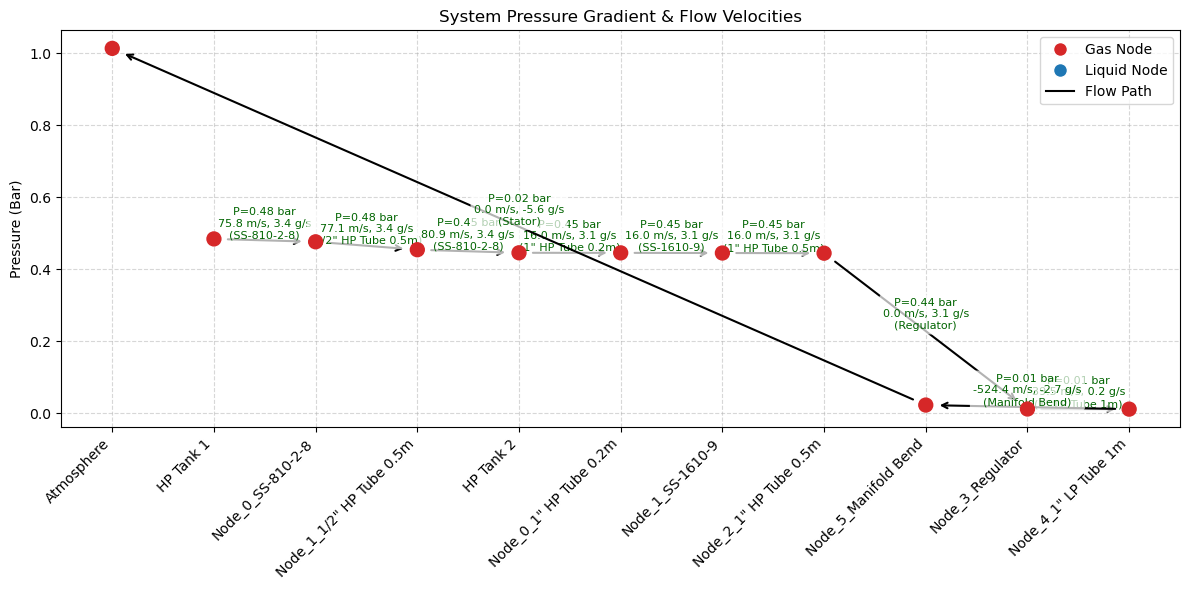

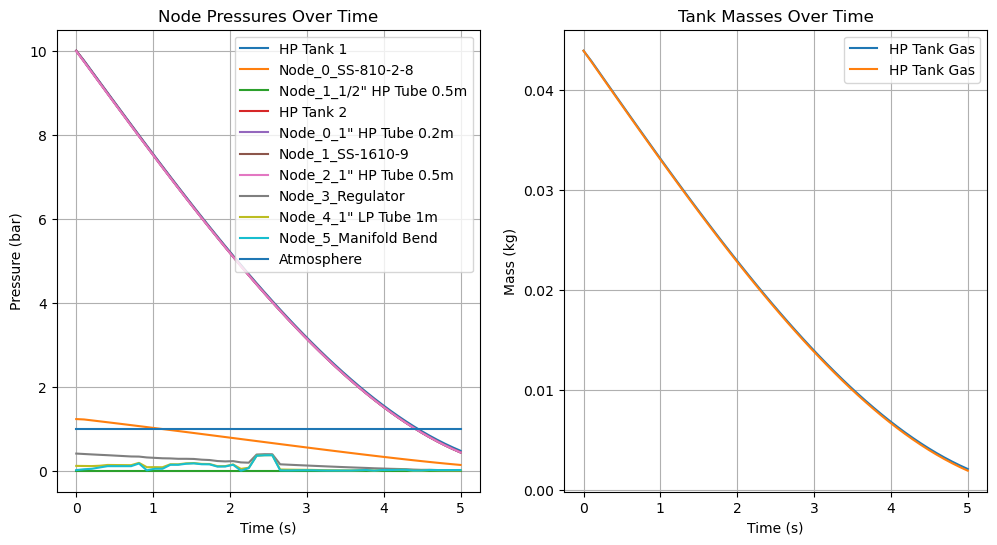

In [2]:
from flowobjects import Gas, Liquid, Tank, FlowComponent, FluidNode, plot_pressure_network, TubeComponent, dae_system, initialize_tanks, timed_valve_kv, regulator_kv, nozzle_kv, create_series_nodes, reg_kv_simple, solve_network_pressures, plot_transient

e_ss = 1.5e-6

air = Gas(name="Air",R= 287, gamma = 1.4, viscosity=1.8e-5)
water = Liquid(name="Water", density = 1000, viscosity=0.001)

hp_tank_1 = Tank(name='HP Tank', volume=3.78 * 0.001, pressure = 10e5, gas=air, gas_temp=300)
hp_bend_1 = TubeComponent(name='SS-810-2-8', D=0.01, L=0.05, roughness=e_ss, bend_ang=90)
hp_tube_1 = TubeComponent(name='1/2" HP Tube 0.5m', D=0.01, L=0.5, roughness=e_ss)
hp_bend_2 = TubeComponent(name='SS-810-2-8', D=0.01, L=0.05, roughness=e_ss, bend_ang=90)
hp_tank_2 = Tank(name='HP Tank', volume=3.78 * 0.001, pressure = 10e5, gas=air, gas_temp=300)
hp_tube_2 = TubeComponent(name='1" HP Tube 0.2m', D=0.022, L=0.2, roughness=e_ss)
hp_bend_3 = TubeComponent(name='SS-1610-9', D=0.022, L=0.1, roughness=e_ss, bend_ang=90)
hp_tube_3 = TubeComponent(name='1" HP Tube 0.5m', D=0.022, L=0.5, roughness=e_ss)
# regulator = FlowComponent(name='Regulator', kv=lambda args: regulator_kv(args, 4e5, 1))
regulator = FlowComponent(name='Regulator', kv=lambda args: reg_kv_simple(args, 4e5, 1.5, p_band=1e4))
lp_tube_1 = TubeComponent(name='1" LP Tube 1m', D=0.022, L=1, roughness=e_ss)
mani_bend = TubeComponent(name='Manifold Bend', D=0.022, L=0.1, roughness=e_ss, bend_ang=90)
stator = FlowComponent(name='Stator', kv=nozzle_kv(23.73e-6))

hp_tank_1_node = FluidNode("HP Tank 1", tank=hp_tank_1)
hp_tank_2_node = FluidNode("HP Tank 2", tank=hp_tank_2)
atmosphere_node = FluidNode("Atmosphere", pressure=101325, constant_pressure=True, temperature=300, fluid=air)

nodes = [hp_tank_1_node] + create_series_nodes(hp_tank_1_node, [hp_bend_1, hp_tube_1, hp_bend_2], hp_tank_2_node) + [hp_tank_2_node] + create_series_nodes(hp_tank_2_node, [hp_tube_2, hp_bend_3, hp_tube_3, regulator, lp_tube_1, mani_bend, stator], atmosphere_node) + [atmosphere_node]
tanks = [hp_tank_1, hp_tank_2]
initial_masses, initial_temperatures = initialize_tanks(tanks)


from scipy.integrate import solve_ivp
import numpy as np

t_end=5
solution = solve_ivp(
    dae_system,
    t_span=(0, t_end),
    y0=initial_masses,
    method='BDF',
    rtol=1e-6,
    atol=1e-9,
    args=(nodes, tanks),
    t_eval=np.linspace(0, t_end, 50)
)





# import cProfile
# cProfile.run("main()", 'restats')
# import pstats
# p = pstats.Stats('restats')
# p.sort_stats('cumulative').print_stats(40)


plot_pressure_network(nodes)
plot_transient(solution, nodes, tanks)



In [10]:
reg_kv_simple((0, 5e5, 3.99999e5), 4e5, 1.5, p_band=1e4)

1.02999998e-06

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# import numpy as np
# import matplotlib.pyplot as plt
# import time

# def rk4_step(t, y, dt, dae_func, nodes, tanks):
#     """
#     Performs a single 4th-order Runge-Kutta step.
#     k1 = f(t, y)
#     k2 = f(t + dt/2, y + dt/2 * k1)
#     k3 = f(t + dt/2, y + dt/2 * k2)
#     k4 = f(t + dt, y + dt * k3)
#     y_next = y + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
#     """
    
#     # 1. k1 - Slope at the beginning
#     # Note: We must COPY 'y' because dae_system modifies node pressures in place
#     # The pressure solver needs the 'y' mass to find pressure, but doesn't change 'y' itself.
#     k1 = np.array(dae_func(t, y, nodes, tanks))
    
#     # 2. k2 - Slope at the midpoint (using k1)
#     y_k2 = y + (dt / 2.0) * k1
#     k2 = np.array(dae_func(t + dt/2.0, y_k2, nodes, tanks))
    
#     # 3. k3 - Slope at the midpoint (using k2)
#     y_k3 = y + (dt / 2.0) * k2
#     k3 = np.array(dae_func(t + dt/2.0, y_k3, nodes, tanks))
    
#     # 4. k4 - Slope at the end (using k3)
#     y_k4 = y + dt * k3
#     k4 = np.array(dae_func(t + dt, y_k4, nodes, tanks))
    
#     # Combine
#     y_next = y + (dt / 6.0) * (k1 + 2.0*k2 + 2.0*k3 + k4)
    
#     return y_next

# def euler_step(t, y, dt, dae_func, nodes, tanks):
#     """
#     Performs a single Euler step.
#     k1 = f(t, y)
#     y_next = y + dt * k1
#     """
#     k1 = np.array(dae_func(t, y, nodes, tanks))
#     y_next = y + dt * k1
#     return y_next

# def run_simulation_rk4(t_end, dt, nodes, tanks, initial_masses):
#     print(f"Starting RK4 Simulation: {t_end}s duration, dt={dt}s")
#     start_time = time.time()
    
#     # 1. Setup
#     t_values = np.arange(0, t_end, dt)
#     n_steps = len(t_values)
#     y = np.array(initial_masses)
    
#     # 2. Storage
#     history_mass = np.zeros((n_steps, len(y)))
#     history_pressure_tanks = np.zeros((n_steps, len(tanks)))
#     # Store pressure of the first variable node (usually downstream of tank)
#     history_pressure_node = np.zeros(n_steps) 

#     # --- THE LOOP ---
#     for i, t in enumerate(t_values):
        
#         # A. Record History
#         history_mass[i] = y
#         for j, tank in enumerate(tanks):
#             history_pressure_tanks[i, j] = tank.pressure
        
#         # Grab a specific node pressure to plot (e.g. Regulator Outlet)
#         # Assuming Node 2 is interesting (adjust index as needed)
#         target_node = nodes[2] if len(nodes) > 2 else nodes[0]
#         history_pressure_node[i] = target_node.pressure if target_node.pressure else 0.0

#         # B. Take the RK4 Step
#         # This calls dae_system 4 times internally
#         y = rk4_step(t, y, dt, dae_system, nodes, tanks)
#         # y = euler_step(t, y, dt, dae_system, nodes, tanks)  
        
#         # C. Crash Protection (Optional)
#         if np.any(np.isnan(y)):
#             print(f"Simulation Exploded at t={t:.3f}s! Mass became NaN.")
#             break

#         # D. Progress Bar
#         if i % 50 == 0:
#             elapsed = time.time() - start_time
#             print(f"Time: {t:.2f}/{t_end}s | Sim Speed: {t/elapsed:.1f}x real-time", end='\r')

#     print(f"\nDone in {time.time() - start_time:.2f}s.")
#     return t_values, history_mass, history_pressure_tanks, history_pressure_node

# def main():
#     # RK4 is stable, so we can use a larger timestep than Euler.
#     # Try 0.005 (5ms) first. If jagged, go to 0.001 (1ms).
#     dt = 0.0002
#     t_end = 0.1
    
#     times, m_hist, p_tank_hist, p_node_hist = run_simulation_rk4(
#         t_end, dt, nodes, tanks, initial_masses
#     )
    
#     # --- PLOTTING ---
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
#     # 1. Pressures
#     for i, tank in enumerate(tanks):
#         ax1.plot(times, p_tank_hist[:, i] / 1e5, linewidth=2, label=f'{tank.name} (Tank)')
    
#     ax1.plot(times, p_node_hist / 1e5, '--', linewidth=1.5, label='Node Pressure (Reg Outlet)')
    
#     ax1.set_ylabel('Pressure (Bar)')
#     ax1.set_title('System Pressures (RK4 Explicit)')
#     ax1.grid(True, which='both', linestyle='--', alpha=0.5)
#     ax1.legend()
    
#     # 2. Masses
#     for i, tank in enumerate(tanks):
#         # Gas mass is usually index 0, 2, 4... (2*i)
#         ax2.plot(times, m_hist[:, 2*i], label=f'{tank.name} Gas Mass')
        
#     ax2.set_ylabel('Mass (kg)')
#     ax2.set_xlabel('Time (s)')
#     ax2.grid(True, which='both', linestyle='--', alpha=0.5)
#     ax2.legend()
    
#     plt.tight_layout()
#     plt.show()

# # Run it
# if __name__ == "__main__":
#     main()